PART 1

In [42]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [36]:
# Step 1: Load the data
df = pd.read_csv("DigitsAccuracy.csv")

In [37]:
# Step 2: Inspect the data
print("Initial Data Preview:")
print(df.head())

Initial Data Preview:
      SVC     RFC     KNC    MLPC
0  0.9750  0.9611  0.9667  0.9750
1  0.9861  0.9750  0.9778  0.9639
2  0.9778  0.9889  0.9750  0.9750
3  0.9778  0.9750  0.9694  0.9722
4  0.9806  0.9806  0.9722  0.9806


In [38]:
# Step 3: Calculate the descriptive statistics (mean and std) for the classifiers' performance
descriptive_stats = df.describe().loc[['mean', 'std']]
print("\nDescriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
           SVC       RFC       KNC      MLPC
mean  0.979460  0.976120  0.972220  0.973340
std   0.004207  0.010143  0.004396  0.006096


In [39]:
# Step 4: Perform One-Way ANOVA to compare the classifier performances
# Reshaping the data for ANOVA (long format)
df_melted = df.melt(var_name="Classifier", value_name="Accuracy")

# Running the ANOVA model
anova_model = ols('Accuracy ~ Classifier', data=df_melted).fit()
anova_result = sm.stats.anova_lm(anova_model, typ=2)

print("\nANOVA Test Result:")
print(anova_result)


ANOVA Test Result:
              sum_sq    df         F   PR(>F)
Classifier  0.000157   3.0  1.178734  0.34896
Residual    0.000708  16.0       NaN      NaN


In [43]:
# Step 5: Perform post-hoc Tukey test if ANOVA is significant
# Tukey HSD test for pairwise comparisons
tukey_result = pairwise_tukeyhsd(df_melted['Accuracy'], df_melted['Classifier'])
print("\nTukey Test Results:")
print(tukey_result.summary())


Tukey Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   KNC   MLPC   0.0011 0.9931 -0.0109 0.0132  False
   KNC    RFC   0.0039 0.7911 -0.0081 0.0159  False
   KNC    SVC   0.0072 0.3457 -0.0048 0.0193  False
  MLPC    RFC   0.0028 0.9102 -0.0093 0.0148  False
  MLPC    SVC   0.0061 0.4859 -0.0059 0.0182  False
   RFC    SVC   0.0033 0.8562 -0.0087 0.0154  False
---------------------------------------------------


In [ ]:

# Step 6: Interpretation of results
# If ANOVA p-value is less than 0.05, we can conclude there are significant differences
# between the classifiers' performances. Tukey's test helps to identify which pairs are different.

PART 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Step 1: Load the dataset
df = pd.read_csv('PonziData.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index, format='%b-%y')

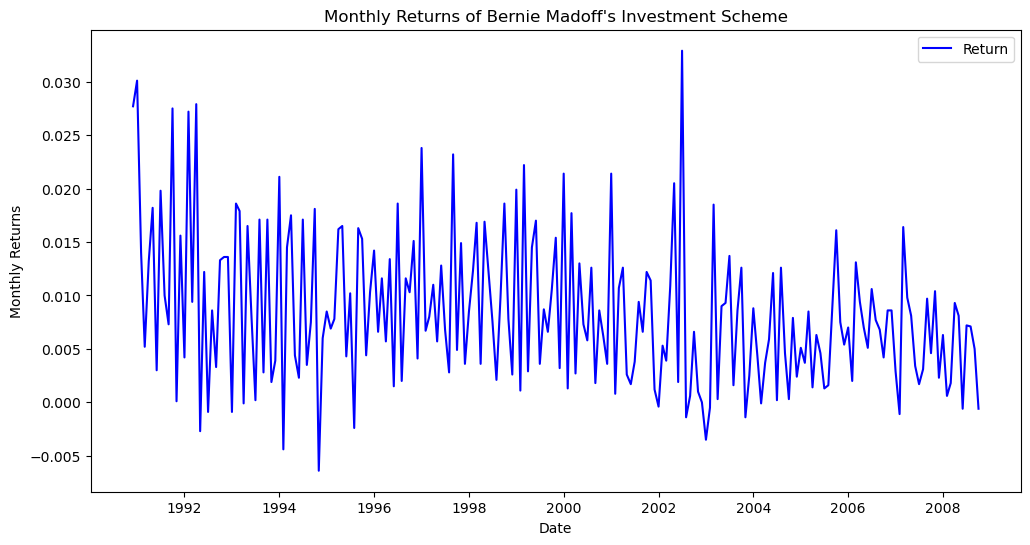

In [26]:
# Step 2: Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Return'], label='Return', color='blue')
plt.title("Monthly Returns of Bernie Madoff's Investment Scheme")
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.legend()
plt.show()

In [27]:
# Step 3: Test for stationarity using the Augmented Dickey-Fuller Test
result = adfuller(df['Return'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.713688428255297
p-value: 0.4240739446083136


In [28]:
# Step 4: Apply differencing if the series is not stationary (if p-value > 0.05)
if result[1] > 0.05:
    df['Differenced'] = df['Return'] - df['Return'].shift(1)
    df.dropna(inplace=True)
    print('Differencing applied to make the series stationary.')

Differencing applied to make the series stationary.


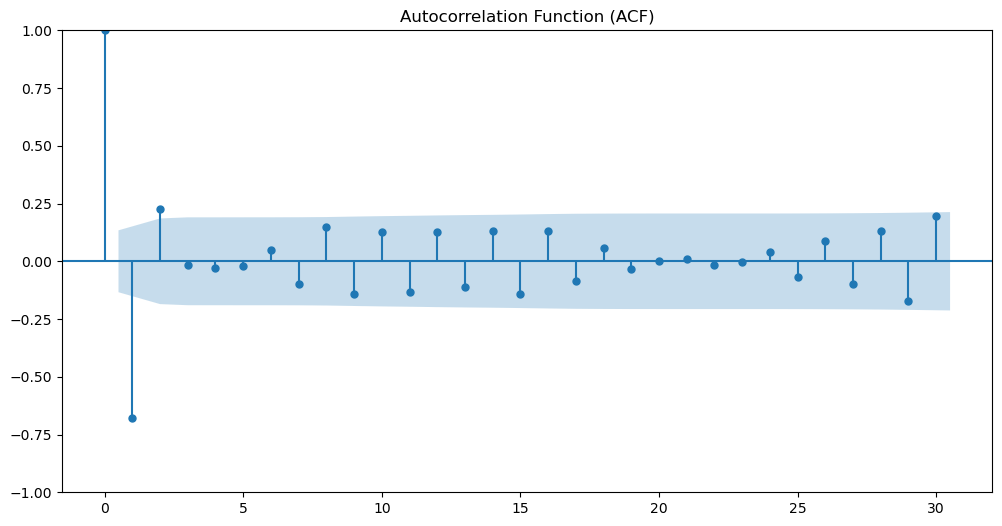

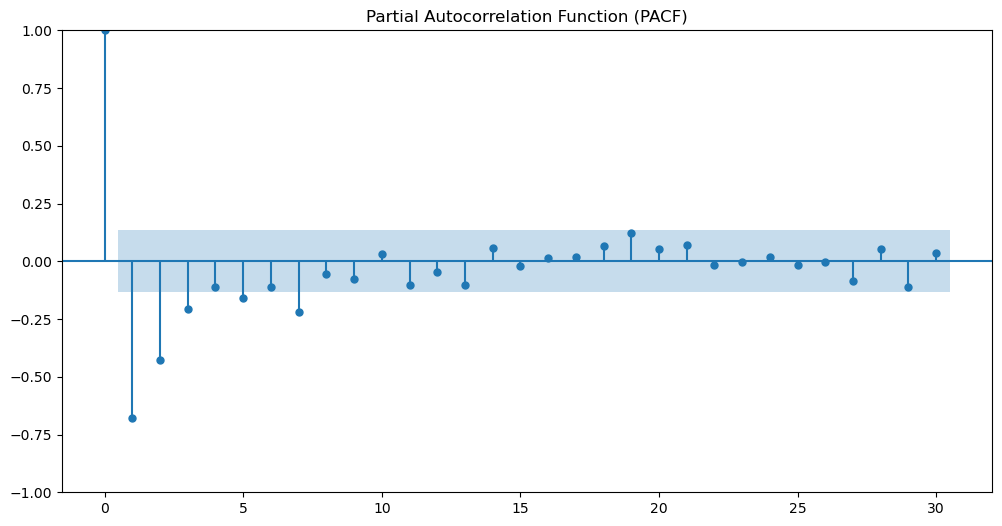

In [29]:
# Step 5: Plot the ACF and PACF to determine the order of AR and MA terms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['Differenced'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Differenced'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [30]:
# Step 6: Split the dataset for training and testing (2007 onwards)
train_data = df[df.index < '2007-01-01']
test_data = df[df.index >= '2007-01-01']

In [31]:
# Step 7: Fit the SARIMA model (ARIMA order: 5,1,0 and seasonal order: 1,1,0,12)
sarima_model = SARIMAX(train_data['Return'],
                       order=(5, 1, 0),               # ARIMA order
                       seasonal_order=(1, 1, 0, 12),  # Seasonal ARIMA
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

In [32]:
# Step 8: Forecast the data for 2007 and 2008
forecast = sarima_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

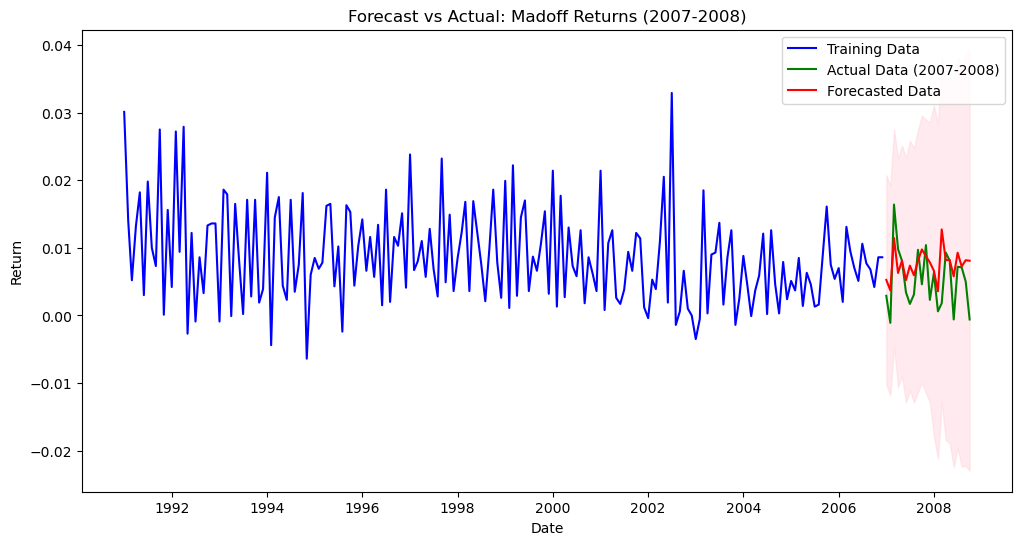

In [33]:
# Step 9: Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Return'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Return'], label='Actual Data (2007-2008)', color='green')
plt.plot(test_data.index, forecast_mean, label='Forecasted Data', color='red')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actual: Madoff Returns (2007-2008)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [34]:
# Step 10: Evaluate model performance using MAE and RMSE
mae = mean_absolute_error(test_data['Return'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['Return'], forecast_mean))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 0.003447063314362389
Root Mean Squared Error (RMSE): 0.004428785969456809
